# Introduction.
As esports increase in popularity and video game streaming becomes more viable as a full-time career, understanding how to increase one’s popularity on the internet is extremely important. If streaming is considered a full-time job, and the number of followers/viewers a person has directly impacts their salary, then knowing when in the week people are most likely to follow or watch can make a big impact on an individuals bottom-line. After all, if people tend to gain the most followers on weekends compared to weekdays then it might be in the streamer’s best interest to put the majority of their hours into working on the weekends in order to maximize their potential growth. 

I selected 11 channels (streamers) whose followings range 8,000 to >60,000. While these aren’t the “superstar” channels on the platform (which have millions of followers), they are channels that are actively trying to grow and would be making at least some revenue from their stream as either a part-time job or full-time. Relatively small and growing channels are also the audience for which this type of data would be the most applicable.

The research questions I'd like to explore are:
1. What day of the week do streamers tend to gain the most followers? 
2. Is there a correlation between longer stream times and number of views? 

# Hypotheses.
A blog post came out at the beginning of this year about what the best time to post on istagram in 2020 is ([blog post](https://later.com/blog/best-time-to-post-on-instagram/)). From analyzing 12 million posts, they were able to isolate the best 3 times of day for each day of the week to have the greatest impact with an instagram post. This got me thinking, are there optimal days of the week to stream? Based on most people working or going to school between 9am-5pm on weekdays, it seems most likely that Fridays and weekends would be the best days of the week to get followers.Therefore my hypotheses are:

1. Channels tend to gain more followers on weekends compared to weekdays.
2. Longer streams (broadcasts) get more views.


# Data.

This data set comes from API requests that I wrote. The data set containing information on followers contains a total of 439,356 observations for the followers of 11 channels ranging in size from ~8,400 to >67,000. Data includes the username and ID of the follower (unique to each follower), date-time of when they followed the channel in question, and the channel they are following. 

The second data set is also from API requests. It contains 410 observations for the most recent 100 (if available) broadcasts made by the same 11 channels. Stored data includes: date-time the broadcast was created, duration of broadcast, view count, ID number of the broadcaster, username of the broadcaster, and type of broadcast. 



In [ ]:
# set up environment
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import math
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# import data sets as Data Frames
twitch_followers = pd.read_csv('https://docs.google.com/spreadsheets/d/1S6Gw1s56VioWFiAoLEV0eC2K_ecwJhjHMQ8QChKyolI/export?format=csv')
twitch_broadcasts = pd.read_csv('https://docs.google.com/spreadsheets/d/1AicubTnVn4oEqGva0d9ePS-_Jp9O03gfClISB1gn9Fs/export?format=csv')

# print out the first few observations for each dataframe
print('twitch_followers data frame')
print(twitch_followers.head(3))
print('--------------------------------')
print('twitch_broadcasts data frame')
print(twitch_broadcasts.head(3))

twitch_followers data frame
             name         id           followed_at following
0         yobrett  418079540  2020-07-14T03:55:33Z    Edgeyy
1   nicki_is_a_qt  542554641  2020-07-14T03:55:05Z    Edgeyy
2  cheater_emeryx  502491302  2020-07-14T03:54:52Z    Edgeyy
--------------------------------
twitch_broadcasts data frame
             created_at  duration  view_count    user_id user_name     type
0  2020-07-14T02:48:41Z   1h9m16s          36  209508256    Edgeyy  archive
1  2020-07-13T19:15:38Z   5h1m45s         313  209508256    Edgeyy  archive
2  2020-07-13T03:51:47Z  4h22m14s         508  209508256    Edgeyy  archive


### As you can see, the 'followed_at', 'created_at', and 'duration' columns are in datetime and time formats. Below are some functions to make them easier to work with. 

In [ ]:
# add new column for just the date, time, weekday (0-6), and hour (0-23) for each follower gained
def add_datetime_columns(df):
    df['dates'] = df['datetime'].dt.date
    df['time'] = df['datetime'].dt.time
    df['weekday'] = df['datetime'].dt.weekday
    df['hour'] = df['datetime'].dt.hour
       
# This function takes the duration and converts it to minutes (not including seconds)
def convert_to_mins(time_series):
    ''' 
    This function takes in a series from the dataframe and converts the
    _h_m_s data to an integer of minutes.
    '''
    converted_time = []
    for t in time_series:
        minutes = 0
        if 'h' in t:
            h = t.split('h')
            minutes += int(h[0])*60
            if 'm' in h[1]:
                m = h[1].split('m')
                minutes += int(m[0])
                if 's' in m[1]:
                    s = m[1].split('s')
                    minutes += round(int(s[0])/60,2)
        elif 'm' in t:
            m = t.split('m')
            minutes += int(m[0])
        else:
            s = t.split('s')
            minutes += round(int(s[0])/60,2)
                
        converted_time.append(minutes)       
    return converted_time


### Use the two functions defined above to add new columns to the dataframes

In [ ]:
# convert datetimes to datetime format
twitch_followers['datetime'] = pd.to_datetime(twitch_followers['followed_at'])
twitch_broadcasts['datetime'] = pd.to_datetime(twitch_broadcasts['created_at'])

# call the function to convert duration to minutes and add that as a new column to the dataframe
twitch_broadcasts['duration_min'] = convert_to_mins(twitch_broadcasts['duration'])

# add date, time, and weekday column to data frames
add_datetime_columns(twitch_followers)
add_datetime_columns(twitch_broadcasts)

In [ ]:
# print out some descriptive information on the data sets
print(twitch_followers.info())
print('--------------')
print(twitch_broadcasts.info())
print('--------------')

# print the number of followers for each of the 11 accounts
print(twitch_followers[['id']].groupby(twitch_followers['following']).agg(['count']))
print('--------------')
# print the number of broadcasts (100 max) for each account
print(twitch_broadcasts.groupby('user_name').agg({'user_id':'count','duration_min':'mean','view_count':'mean'}).sort_values(by=['duration_min'], ascending = False))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 439357 entries, 0 to 439356
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype              
---  ------       --------------   -----              
 0   name         439357 non-null  object             
 1   id           439357 non-null  int64              
 2   followed_at  439357 non-null  object             
 3   following    439357 non-null  object             
 4   datetime     439357 non-null  datetime64[ns, UTC]
 5   dates        439357 non-null  object             
 6   time         439357 non-null  object             
 7   weekday      439357 non-null  int64              
 8   hour         439357 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(3), object(5)
memory usage: 30.2+ MB
None
--------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411 entries, 0 to 410
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        -----------

From the duration column, sorted in descending order, you can see that the highest average highest view counts do not necessarily correspond with the highest average duration.

# Methods.

First I will plot the trajectory of channel growth for each of the 11 channels. Since we are interested in how to best maximize follower growth, it is important to know if most channels follow a predictable trajectory. 

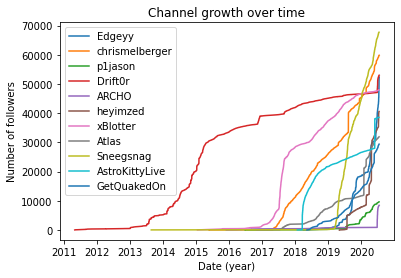

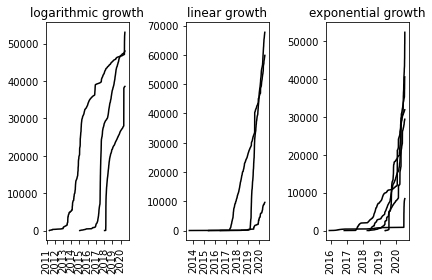

In [ ]:
from google.colab import files
def plot_channel_growth(column = 'dates', channel_list = None, color = None):
    ''' this function will plot the growth of channels over time. By default
    it will plot all 11 channels against date, but inputs could be changed to
    plot vs time instead'''
    
    if channel_list == None:
        channel_list = twitch_followers['following'].unique()
    
    for channel in channel_list:  
        channel_df = twitch_followers[[column]].iloc[(twitch_followers['following']==channel).values]
        channel_df.sort_values(by = [column],axis=0,inplace = True)
        
        num_followers = list(range(0,len(channel_df[column])))
        
        channel_df['num_followers'] = num_followers
        if color == None:
            plt.plot(channel_df[column], channel_df['num_followers'])
        else:
            plt.plot(channel_df[column], channel_df['num_followers'], color = color)
    return

# plot all 11 channels
plot_channel_growth()
plt.title('Channel growth over time')
plt.ylabel('Number of followers')
plt.xlabel('Date (year)')
plt.legend(twitch_followers['following'].unique())

# make a new figure
plt.figure()

# plot channels with logarithmic growth
ax1 = plt.subplot(1,3,1)
plot_channel_growth(channel_list = ['Drift0r','xBlotter','AstroKittyLive'], color = 'black')
plt.title('logarithmic growth')
plt.xticks(rotation=90)

# plot channels with linear growth
ax2 = plt.subplot(1,3,2)
plot_channel_growth(channel_list = ['chrismelberger','Sneegsnag','p1jason'], color = 'black')
plt.title('linear growth')
plt.xticks(rotation=90)

# plot channels with exponential growth
ax3 = plt.subplot(1,3,3)
plot_channel_growth(channel_list = ['Edgeyy', 'ARCHO','heyimzed','Atlas','GetQuakedOn'], color = 'black')
plt.title('exponential growth')
plt.xticks(rotation=90)

plt.tight_layout()


From this plot you can see that there are 3 different types of trajectories for channel growth.
- Logarithmic: Drift0r (red), xBlotter (pink), and AstrokittyLive (blue) 
- Linear: chrismelberger (orange), Sneegsnag (gold), p1jason (green)
- Exponential: Edgeyy (dark blue), ARCHO (purple), heyimzed (brown), Atlas (grey), GetQuakedOn (medium blue)

Since we can see that not all channels grow in the same way, it will be interesting to compare if different days of the week get different amounts of followers across the 11 channels.

To test this, I will group the number of follower for each day of the week per channel and plot histograms of the distributions. If they are normally distributed, then I will conduct independent t-tests to see if there are significant differences between each day of the week. If they are non-normal, then I will use a non-parametric test. Also, because each account has different numbers of total followers, I will be plotting percentage of followers gained on each day of the week rather than gross values in order to normalize the data.

DescribeResult(nobs=55, minmax=(3.698957588900663, 36.43111099576986), mean=13.750612092492789, variance=36.967615095734615, skewness=1.7658990404648378, kurtosis=3.89345016768112)
DescribeResult(nobs=22, minmax=(3.6579572446555817, 38.38146301696297), mean=15.623469768768034, variance=62.441504485170775, skewness=1.5433777684329755, kurtosis=2.575352789634694)
---------------------------
 Shapiro-Wilk tests
Weekdays:  (0.8377063274383545, 3.0860328479320742e-06)
Weekends including Fridays:  (0.8168548941612244, 0.0009296862408518791)


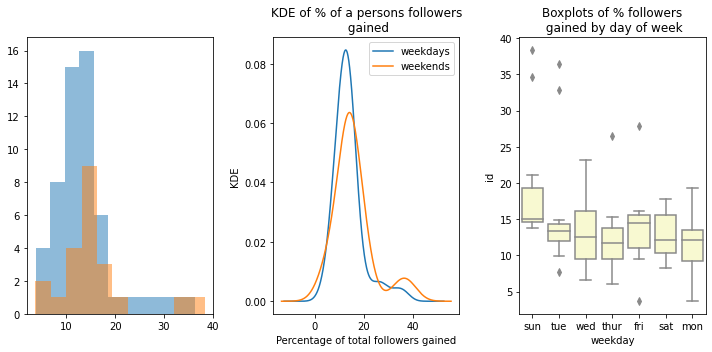

In [ ]:
# aggregate the number of followers gained by day of the week for each channel
followers_by_day = twitch_followers.groupby(['weekday','following']).agg({'id':'count'}).reset_index()
# aggregate the total number of followers each channel has
total_followers = followers_by_day.groupby('following').agg({'id':'sum'}).reset_index()

# for each of the 11 channels
for channel in total_followers['following'].unique():
    # replace the count number of followerers gained by weekday with a percentage of followers gained for each channel by day of the week
    followers_by_day.loc[followers_by_day[['id']].loc[(followers_by_day['following'] == channel).values].index.values.tolist(),'id'] = list((followers_by_day['id'].loc[(followers_by_day['following'] == channel).values])/int(total_followers['id'].loc[total_followers['following'] == channel])*100)

fig = plt.figure()
fig.set_size_inches(10,5)
ax1 = plt.subplot(1,3,1)
# plot weekdays
weekday_follows = followers_by_day['id'].loc[(followers_by_day['weekday'] >0) & (followers_by_day['weekday'] < 6)]
plt.hist(weekday_follows, bins = 11, alpha = 0.5)
# plot weekends including fridays
weekend_follows = followers_by_day['id'].loc[(followers_by_day['weekday'] == 0) | (followers_by_day['weekday'] >= 6)]
plt.hist(weekend_follows, bins = 11, alpha = 0.5)

ax2 = plt.subplot(1,3,2)
weekday_follows.plot.kde()
weekend_follows.plot.kde()

plt.legend(['weekdays','weekends','fridays'])
plt.ylabel('KDE')
plt.xlabel('Percentage of total followers gained')
plt.title('KDE of % of a persons followers\n gained')

ax3 = plt.subplot(1,3,3)
sns.boxplot(x='weekday',y='id',data = followers_by_day, color = 'xkcd:ivory')
plt.xticks([0,1,2,3,4,5,6],['sun','tue','wed','thur','fri','sat','mon'])
plt.title('Boxplots of % followers\n gained by day of week')

plt.tight_layout()

print(stats.describe(weekday_follows))
print(stats.describe(weekend_follows))

# use the Shapiro-Wilk test to test for normality
print('---------------------------\n Shapiro-Wilk tests')
print('Weekdays: ', stats.shapiro(weekday_follows))
print('Weekends including Fridays: ',stats.shapiro(weekend_follows))


From the histograms, you can see that neither the weekend or weekday results look super normal. and the skewness and kurtosis levels are relatively high. However, the Shapiro-Wilk tests return W values close to 1, and p values < 0.0001, which would point towards normality. However, based on the visual skewness of the histograms, we will assume the weekend and weekday data are closer to not-normally distributed and will therefore use a non-parametric test to compare the two data sets.

In the boxplot distributions it visually appears that Tuesday - Monday are very similar, whereas Sunday might be the only day that stands out. 

In [ ]:
stats.kruskal(weekday_follows, weekend_follows)

KruskalResult(statistic=1.7108709472345538, pvalue=0.19087240853693302)

Based on the statistic and p-value, we cannot reject the null that the samples have the same distribution. 

Therefore, to answer our first research question: There is seemingly no significant difference between weekends and weekdays for gaining followers. 

This result brings into question whether time of day might be a more significant factor than day of the week?

0         03:55:33
1         03:55:05
2         03:54:52
3         03:54:27
4         03:54:08
            ...   
439352    08:09:25
439353    01:27:02
439354    16:15:01
439355    14:08:42
439356    08:33:30
Name: time, Length: 439357, dtype: object

Text(0.5, 1.0, 'Followers gained throughout the day')

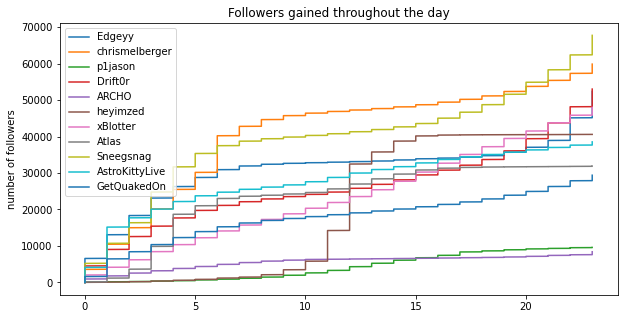

In [ ]:
fig = plt.figure()
fig.set_size_inches(10,5)
# plot the growth of channels by time
plot_channel_growth(column = 'hour')
plt.legend(twitch_followers['following'].unique())
plt.ylabel('number of followers')
plt.title('Followers gained throughout the day')

The steepest slopes in the plot show the times of day where 
the most followers were gained. As you can see, most channels
plateau in growth during the day between 5:00 am and 5:00 pm.
However, one channel, heyimzed, seems to grow the most in
the afternoon.

Why might this be? All of the channels selected are English speaking, and so at first I assumed that all of the streamers were based in North America. However, upon further investigation it is revealed that heyimzed is based in Australia! That would explain why he gains followers ~12 hours offset from when all of the other streamers gain followers. It is because either 1. the majority of his followers are likely either Australians or 2. he streams at those times more exclusively.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

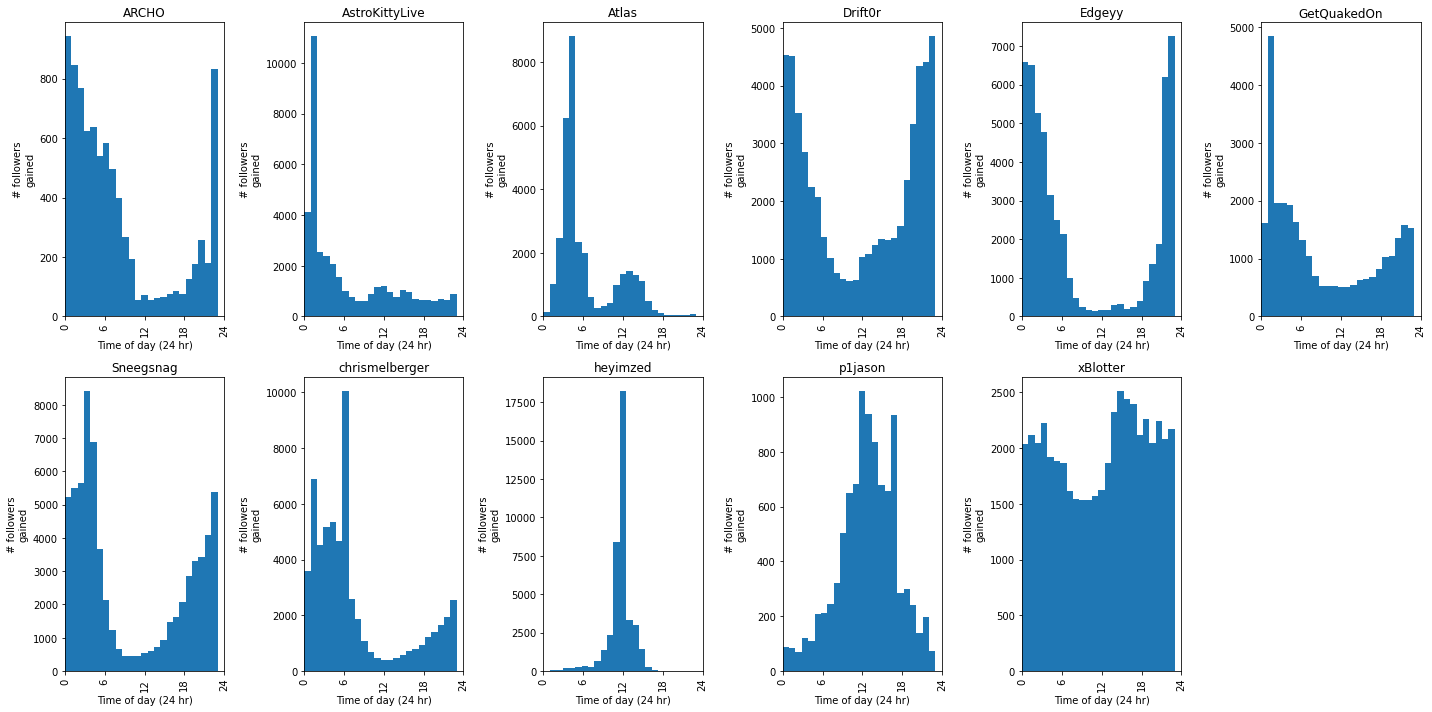

In [ ]:
def plot_time_hist():    
    fig = plt.figure()
    fig.set_size_inches(20, 10)
    axis = 1
    
    for channel in total_followers['following'].unique():
        time_df = twitch_followers[['time']].iloc[(twitch_followers['following']==channel).values]
        hour_list = [t.hour for t in time_df['time']] 
                     
        ax = plt.subplot(2,6,axis)
        plt.hist(hour_list, bins = 24)
        plt.title(channel)
        plt.xlim([0, 24])
        plt.xticks([0,6,12,18,24], rotation = 90)
        plt.ylabel('# followers\ngained')
        plt.xlabel('Time of day (24 hr)')
        
        axis += 1
    plt.tight_layout()
        
plot_time_hist()
plt.savefig('fig.png')
files.download('fig.png')

Although seeing what time gains the most followers wasn't one of our research questions, these histograms show that between 5:00 pm and 5:00 am are the peak streaming hours. Only two streamers, heyimzed and p1jason, seem to diverge from this.

Only heyimzed and p1jason seem to differ in when they gain the most followers. We already deterined that for heyimzed the reason behind this is because he is Australian, however in the case of p1jason, he is from NYC. Therefore, the reason why his histogram looks different may be because he chooses to stream during the day rather than at night, thereby forcing his followers to primarily be gained during the day.

The 2nd research question pertains to the twitch_broadcasts data set. To answer the question of whether there is a correlation betewen broadcast duration and views, I will simply create a scatter plot of the two variables and calculate the correlation coefficient.

KruskalResult(statistic=83.5524382840824, pvalue=6.204806402202586e-20)
The difference in means at the 95% confidence interval (two-tail) is between 3.4% and 5.25%.
2.003395452720004
6.329937880613329


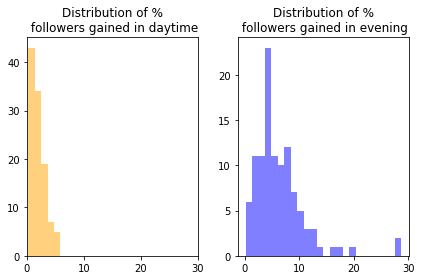

In [ ]:
# calculate the 95% confidence interval bewtween 
# number of followers gained between 5:00 am - 5:00 pm and 5:00 pm - 5:00 am.

# increase preciscion for decimal division
from decimal import Decimal, getcontext

followers_by_hour = twitch_followers.groupby(['hour','following']).agg({'id':'count'}).reset_index()
followers_by_hour = followers_by_hour[followers_by_hour['following'] !='heyimzed']
followers_by_hour = followers_by_hour[followers_by_hour['following'] !='p1jason']
total_followers = followers_by_hour.groupby('following').agg({'id':'sum'}).reset_index()

# for each of the 11 channels
for channel in total_followers['following'].unique():
    # replace the number of followerers gained by hour with a percentage of followers gained for each channel at that hour
    followers_by_hour.loc[followers_by_hour[['id']].loc[(followers_by_hour['following'] == channel).values].index.values.tolist(),'id'] = list((followers_by_hour['id'].loc[(followers_by_hour['following'] == channel).values])/int(total_followers['id'].loc[total_followers['following'] == channel])*100)

def get_95_ci(array_1, array_2):
    ''' function that takes in two arrays and
    calculates the 95% confidence interval of
    the difference in means of the two groups'''
    sample_1_n = array_1.shape[0]
    sample_2_n = array_2.shape[0]
    sample_1_mean = array_1.mean()
    sample_2_mean = array_2.mean()
    sample_1_var = array_1.var()
    sample_2_var = array_2.var()
    mean_difference = sample_2_mean - sample_1_mean
    std_err_difference = math.sqrt((sample_1_var/sample_1_n)+(sample_2_var/sample_2_n))
    margin_of_error = 1.96 * std_err_difference
    ci_lower = mean_difference - margin_of_error
    ci_upper = mean_difference + margin_of_error
    print("The difference in means at the 95% confidence interval (two-tail) is between "+str(round(ci_lower,2))+"% and "+str(round(ci_upper,2))+"%.")
    return

# evening equals hours between 5pm and 5am
evening = followers_by_hour['id'].loc[followers_by_hour['hour']<= 6].append(followers_by_hour['id'].loc[followers_by_hour['hour'] > 18])
daytime = followers_by_hour['id'].loc[(followers_by_hour['hour'] > 6) & (followers_by_hour['hour'] <= 18)]

# kruskal test
print(stats.kruskal(evening, daytime))
# calculate confidence interval
get_95_ci(daytime, evening)

plt.subplot(1,2,1)
plt.hist(daytime,alpha=.5,bins = 5,color='orange')
plt.title('Distribution of %\n followers gained in daytime')
plt.xlim([0,30])
plt.subplot(1,2,2)
plt.hist(evening,alpha=.5,bins = 24,color = 'blue')
plt.title('Distribution of %\n followers gained in evening')
plt.tight_layout()
from statistics import mean
print(mean(daytime))
print(mean(evening))

The Kruskal-wallis test shows that there is a difference between the means of the % of followers gained during the day vs during the evening, and the p-value <0.0001 gives us confidence that this is a real difference. The confidence interval tells us that the difference in means between the two groups is between 1.91% and 3.86%. This may not seem like a huge difference, but the larger a channel becomes, the more signifanct even a 3% increase in followers can become.

TypeError: ignored

TypeError: ignored

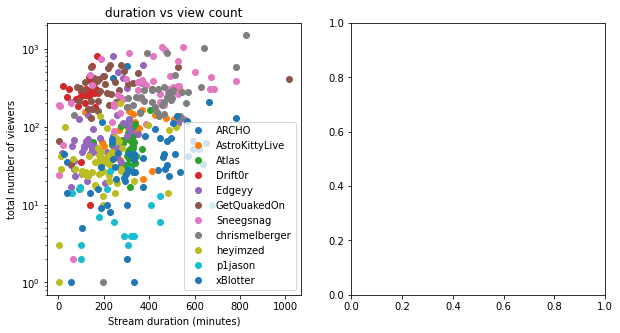

In [ ]:
# group data by channel
groups = twitch_broadcasts.groupby('user_name')

fig = plt.figure()
fig.set_size_inches(10,5)

ax1 = plt.subplot(1,2,1)
for name, group in groups:
    plt.plot(group['duration_min'], group['view_count'], marker = 'o', linestyle='',label=name)
plt.legend()
plt.title('duration vs view count')
plt.xlabel('Stream duration (minutes)')
plt.ylabel('total number of viewers')
plt.yscale('log')

ax2 = plt.subplot(1,2,2)
for name, group in groups:
    plt.plot(group['time'], group['view_count'], marker = 'o', linestyle='',label=name)
plt.legend()
plt.title('time of day vs view count')
plt.xlabel('Time of day (hh:mm:ss)')
plt.ylabel('total number of viewers')

plt.tight_layout()

# do a Pearson correlation test
stats.pearsonr(twitch_broadcasts['duration_min'],twitch_broadcasts['view_count'])

plt.savefig('duration.png')
files.download('duration.png')

# Results. 

We found that the day of the week does not play a significant role in when followers were gained. Time of day, however does play a major role in gaining new followers, with the most follows occuring between 5:00 pm and 5:00 am.

There also doesn't appear to be any strong correlation between stream duration and viewer count. The correlation coefficient is 0.29, which is very low, and the p-value is <0.0001, which gives us confidence in these results.

This answers our second research question by showing that stream duration doesn't affect the number of views. However, time of day does affect the view count, with the greatest number of viewers occurring between 5:00 pm and 5:00 am. Very similar to the time range that gained the most followers!

# Discussion and recommendation.
Our results show that in order to grow your following, the most important factor is time of day. As a next step to test these results, I would look further into what is driving views/followers in the evening. Is it just because that is the most frequent time that people choose to stream because of day-jobs?

I would also propose an A/B test that randomly selected some channels and limited when they could stream to 1 hour time periods, at the same time of day, everyday for 2 weeks. 

After two weeks we could then follow up and see if there was a significant difference in the number of followers gained by accounts streaming exclusively in the evening compared to accounts that streamed exclusively during the day.